In [ ]:
import pandas as pd
from pathlib import Path
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
import numpy as np
from statsmodels.nonparametric.smoothers_lowess import lowess

In [3]:
height_data_path = Path('/workspaces/nrg_interview_prep/data/height_data.csv')
raw_data_df = pd.read_csv(height_data_path)
raw_data_df.head()

,height,weight,age,male
0,151.765,47.825606,63.0,1
1,139.700,36.485807,63.0,0
2,136.525,31.864838,65.0,0
3,156.845,53.041914,41.0,1
4,145.415,41.276872,51.0,0


### Take a look the the relationships between each independent variable and height - the dependent variable.

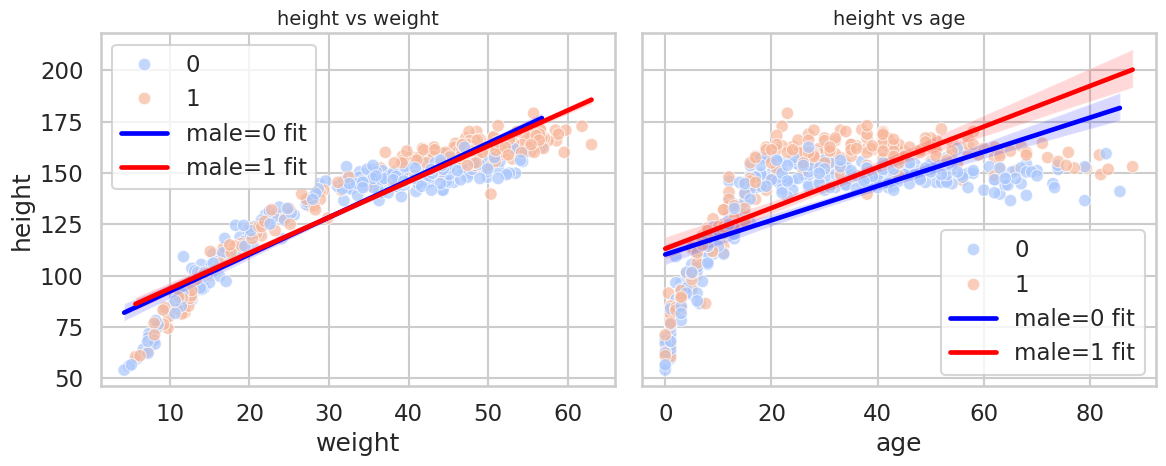

In [4]:
# Set up the plot style
sns.set_theme(style="whitegrid", context="talk")

# Create 1 row, 2 columns of subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharey=True)

# List of independent variables
x_vars = ['weight', 'age']

# Plot each relationship with color-coded binary male vs female labels
for i, x in enumerate(x_vars):
    sns.scatterplot(
        data=raw_data_df,
        x=x,
        y='height',
        hue='male',
        palette='coolwarm',
        alpha=0.7,
        ax=axes[i]
    )

    # Add optional regression lines for each class
    sns.regplot(
        data=raw_data_df[raw_data_df['male'] == 0],
        x=x,
        y='height',
        scatter=False,
        ax=axes[i],
        color='blue',
        label='male=0 fit'
    )
    sns.regplot(
        data=raw_data_df[raw_data_df['male'] == 1],
        x=x,
        y='height',
        scatter=False,
        ax=axes[i],
        color='red',
        label='male=1 fit'
    )

    axes[i].set_title(f'height vs {x}', fontsize=14)
    axes[i].set_xlabel(x)
    axes[i].set_ylabel('height' if i == 0 else '')
    axes[i].legend()

plt.tight_layout()
plt.show()

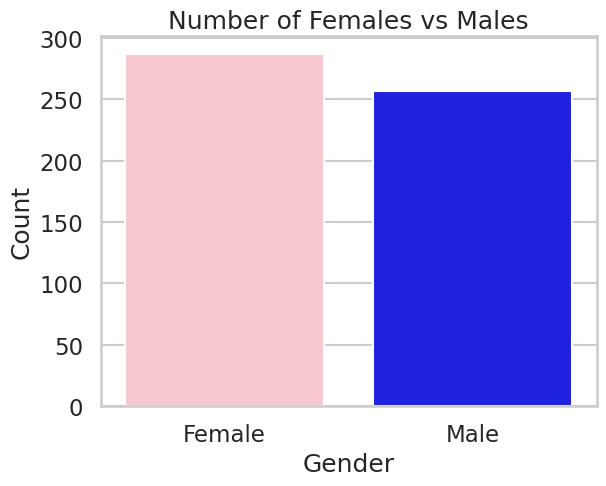

In [5]:
sns.countplot(x='male', hue='male', data=raw_data_df, palette={0:'pink', 1:'blue'}, legend=False)
plt.xticks([0,1], ['Female', 'Male'])
plt.ylabel('Count')
plt.xlabel('Gender')
plt.title('Number of Females vs Males')
plt.show()

In [ ]:
# General model ignoring sex
general_model = smf.ols('height ~ weight', data=raw_data_df).fit()
#print(general_model.summary())

slope_general = general_model.params['weight']
height_change_per_10_general = 10 * slope_general

print(f"General: For every 10 units of weight, height increases by {height_change_per_10_general:.2f} units.")

General: For every 10 units of weight, height increases by 17.64 units.


In [7]:
# Model with interaction: allows weight effect to differ by gender
gender_model = smf.ols('height ~ weight * male', data=raw_data_df).fit()
#print(gender_model.summary())

# Extract coefficients
b_weight = gender_model.params['weight']           # slope for females (male=0)
b_interaction = gender_model.params['weight:male'] # additional slope for males

# Height increase per 10 units of weight
height_change_female = 10 * b_weight
height_change_male = 10 * (b_weight + b_interaction)

print(f"Female: For every 10 units of weight, height increases by {height_change_female:.2f} units.")
print(f"Male:   For every 10 units of weight, height increases by {height_change_male:.2f} units.")



Female: For every 10 units of weight, height increases by 18.05 units.
Male:   For every 10 units of weight, height increases by 17.36 units.


$$
\text{height} \sim \text{weight} + \text{weight}^2 + \text{age} + \text{age}^2 + \text{male} + 
(\text{weight} \times \text{male}) + (\text{age} \times \text{male})
$$

### Model Specification: Height as a Function of Weight, Age, and Gender

This model predicts a person's **height** using their **weight**, **age**, and **gender** (`male` = 1, `female` = 0).  
The equation includes both **linear** and **quadratic** terms for weight and age, as well as **interaction effects** with gender.

Including quadratic terms allows the model to capture **nonlinear relationships** — for example, the idea that height tends to increase quickly with weight at lower weights (children or smaller individuals), but the rate of increase slows down as people become heavier or older.  
Interaction terms with gender allow the model to estimate **different relationships** between weight, age, and height for males versus females.

$$
\text{height} \sim \text{weight} + \text{weight}^2 + \text{age} + \text{age}^2 + \text{male} +
(\text{weight} \times \text{male}) + (\text{age} \times \text{male})
$$

**Interpretation notes:**
- The coefficient on **`weight`** represents how height changes with weight *for females* (since `male=0`).
- The coefficient on **`weight × male`** captures how that relationship differs for males.
- The **quadratic terms** (`weight²`, `age²`) allow for curvature — the marginal effect of weight or age on height changes as those variables increase.
- To compute the change in height for a 10-unit increase in weight, you can calculate the **marginal effect** of weight at a given point:
  $$
  \frac{d(\text{height})}{d(\text{weight})} = \beta_{\text{weight}} + 2\beta_{\text{weight}^2}(\text{weight}) + \beta_{\text{weight:male}}(\text{male})
  $$

This gives a flexible, interpretable model that respects the biological reality that growth slows over time and differs by gender.


In [ ]:
# Fit model with nonlinear terms and interactions
formula = """
height ~ weight + I(weight**2) + age + I(age**2) + male +
          weight:male + age:male
"""
model = smf.ols(formula, data=raw_data_df).fit()
#print(model.summary())

# Extract coefficients
b = model.params

def marginal_effects(weight, age, male, model_params):
    """Return partial derivatives wrt weight and age."""
    d_height_d_weight = (
        b['weight']
        + 2 * b['I(weight ** 2)'] * weight
        + b.get('weight:male', 0) * male
    )
    d_height_d_age = (
        b['age']
        + 2 * b['I(age ** 2)'] * age
        + b.get('age:male', 0) * male
    )
    return d_height_d_weight, d_height_d_age


In [ ]:
# Grid of ages to evaluate
age_grid = np.linspace(raw_data_df['age'].min(), raw_data_df['age'].max(), 100)

# Smooth typical weight as a function of age, separately by sex
smoothed_weight_by_sex = {}
frac = 0.25  # smoothing; tune 0.1–0.5 depending on noise

for male_flag in [0, 1]:
    sub = raw_data_df[raw_data_df['male'] == male_flag]
    if len(sub) < 10:
        # fallback: use global smoother if too few for this sex
        lw = lowess(raw_data_df['weight'], raw_data_df['age'], frac=frac, return_sorted=True)
    else:
        lw = lowess(sub['weight'], sub['age'], frac=frac, return_sorted=True)

    smoothed_weight = np.interp(age_grid, lw[:, 0], lw[:, 1])
    smoothed_weight_by_sex[male_flag] = smoothed_weight

# Choose age percentiles to summarize
age_percentiles = [10, 25, 50, 75, 90]
age_vals = np.percentile(df['age'], age_percentiles)

results = []
for a in age_vals:
    for male_flag in [0, 1]:
        # Typical weight for this sex at this age (interpolated)
        typical_weight = float(np.interp(a, age_grid, smoothed_weight_by_sex[male_flag]))
        d_w, d_a = marginal_effects(typical_weight, a, male_flag)
        results.append({
            'Age': round(a, 2),
            'Male': 'Male' if male_flag else 'Female',
            'Typical Weight': round(typical_weight, 2),
            'd_height_per_1_weight': round(d_w, 4),
            'height_gain_per_10_weight': round(d_w * 10, 4)
        })

rep_df_age_smooth = pd.DataFrame(results)
rep_df_age_smooth


,Age,Male,Typical Weight,d_height_per_1_weight,height_gain_per_10_weight
0,3.0,Female,10.96,3.5291,35.2906
1,3.0,Male,12.07,3.7412,37.4118
2,12.0,Female,23.10,2.3963,23.9635
3,12.0,Male,25.33,2.5036,25.0357
4,27.0,Female,42.47,0.5883,5.8828
5,27.0,Male,48.65,0.3276,3.2761
6,43.0,Female,41.50,0.6790,6.7898
7,43.0,Male,50.32,0.1723,1.7227
8,58.0,Female,40.59,0.7640,7.6397
9,58.0,Male,46.83,0.4971,4.9713


In [21]:
weight_grid = np.linspace(raw_data_df['weight'].min(), raw_data_df['weight'].max(), 100)
smoothed_age_by_sex = {} # smoothing; adjust (0.1-0.5) depending on noise
frac = 0.25  # smoothing; adjust (0.1-0.5) depending on noise
for male_flag in [0, 1]:
    sub = raw_data_df[raw_data_df['male'] == male_flag]
    if len(sub) < 10:
        # fallback: use global smoothing if too few points by sex
        lw = lowess(raw_data_df['age'], raw_data_df['weight'], frac=frac, return_sorted=True)
    else:
        lw = lowess(sub['age'], sub['weight'], frac=frac, return_sorted=True)
    # interpolate onto common weight grid
    smoothed_age = np.interp(weight_grid, lw[:, 0], lw[:, 1])
    smoothed_age_by_sex[male_flag] = smoothed_age

# choose weight percentiles to present (for example)
weight_percentiles = [10, 25, 50, 75, 90]
weight_vals = np.percentile(df['weight'], weight_percentiles)

results = []
for w in weight_vals:
    for male_flag in [0, 1]:
        # typical age for this sex at this weight (interpolated)
        typical_age = float(np.interp(w, weight_grid, smoothed_age_by_sex[male_flag]))
        d_w, d_a = marginal_effects(w, typical_age, male_flag)
        results.append({
            'Weight': round(w, 2),
            'Male': 'Male' if male_flag else 'Female',
            'Typical Age': round(typical_age, 2),
            'd_height_per_1_weight': round(d_w, 4),
            'height_gain_per_10_weight': round(d_w * 10, 4)
        })

rep_df_smooth = pd.DataFrame(results)
rep_df_smooth

,Weight,Male,Typical Age,d_height_per_1_weight,height_gain_per_10_weight
0,12.54,Female,4.31,3.3818,33.8178
1,12.54,Male,3.66,3.6976,36.9764
2,22.01,Female,11.62,2.4981,24.9813
3,22.01,Male,10.38,2.8140,28.1399
4,40.06,Female,38.99,0.8137,8.1366
5,40.06,Male,25.42,1.1295,11.2951
6,47.21,Female,33.70,0.1463,1.4629
7,47.21,Male,39.06,0.4622,4.6215
8,51.56,Female,33.45,-0.2599,-2.5994
9,51.56,Male,38.68,0.0559,0.5591


In [14]:
# Define range of ages and weights you want to cover
ages = np.linspace(raw_data_df["age"].min(), raw_data_df["age"].max(), 50)
weights = np.linspace(raw_data_df["weight"].min(), raw_data_df["weight"].max(), 50)

# Build grid for both sexes
grid = pd.DataFrame(
    [(a, w, m) for a in ages for w in weights for m in [0, 1]],
    columns=["age", "weight", "male"]
)

In [17]:
import joblib

# Save model
joblib.dump(model, f"/workspaces/nrg_interview_prep/data/height_model.pkl")

['/workspaces/nrg_interview_prep/data/height_model.pkl']